In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import xgboost as xgb
import joblib

In [ ]:
# Load dataset
df = pd.read_csv('crime_emergencies.csv')
df.columns = [c.strip() for c in df.columns]

In [ ]:
df.head()

,Date,Year,Time,Day_of_Week,Barangay,Latitude,Longitude,Weather,Crime_Type,Crime_Cause,Severity,Arrests,Response_Time,Incident_Duration
0,09/10/2025,2025,0:22,Friday,San Mateo (Imok),14.031094,121.333158,Sunny,Harassment,Other,Low,2,30,113
1,01/11/2022,2022,21:42,Sunday,III-E,14.106046,121.312662,Sunny,Harassment,Alcohol,Medium,3,30,116
2,24/05/2020,2020,22:01,Wednesday,II-C (Unson),14.080902,121.281272,Sunny,Theft,Personal Dispute,High,3,9,69
3,24/07/2020,2020,18:35,Sunday,VII-D,14.090744,121.320815,Sunny,Robbery,Unemployment,Medium,0,9,19
4,03/07/2025,2025,4:06,Wednesday,VI-D (Lakeside),14.050497,121.347081,Cloudy,Assault,Gang Activity,High,2,16,107


In [ ]:
df.columns

Index(['Date', 'Year', 'Time', 'Day_of_Week', 'Barangay', 'Latitude',
       'Longitude', 'Weather', 'Crime_Type', 'Crime_Cause', 'Severity',
       'Arrests', 'Response_Time', 'Incident_Duration'],
      dtype='object')

In [ ]:
df.shape

(1500, 14)

In [ ]:
# Handle missing values
df = df.dropna(subset=['Year', 'Barangay', 'Crime_Type', 'Crime_Cause', 'Severity'])

In [ ]:
# Define features and target
X = df[['Year', 'Barangay', 'Crime_Type', 'Crime_Cause']]
y = df['Severity'].apply(lambda x: 1 if x in ['Medium', 'High'] else 0)  # 1 for severe, 0 for low



In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['Year']),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), ['Barangay', 'Crime_Type', 'Crime_Cause'])
    ],
    remainder='drop'
)


In [ ]:
# XGBoost pipeline
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        n_estimators=400,
        max_depth=9,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    ))
])



In [ ]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)



In [ ]:
# Train model
pipe.fit(X_train, y_train)



Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Year']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Barangay', 'Crime_Type',
                                                   'Crime_Cause'])])),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8, devi...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=400, n_jobs=None,
                               num_parallel_tree=None, ...))])

In [ ]:
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

In [ ]:

print("=== XGBoost - Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))



=== XGBoost - Classification Report ===
              precision    recall  f1-score   support

           0     0.3523    0.2168    0.2684       143
           1     0.6906    0.8143    0.7474       307

    accuracy                         0.6244       450
   macro avg     0.5214    0.5156    0.5079       450
weighted avg     0.5831    0.6244    0.5952       450



=== XGBoost - Confusion Matrix ===
[[ 31 112]
 [ 57 250]]


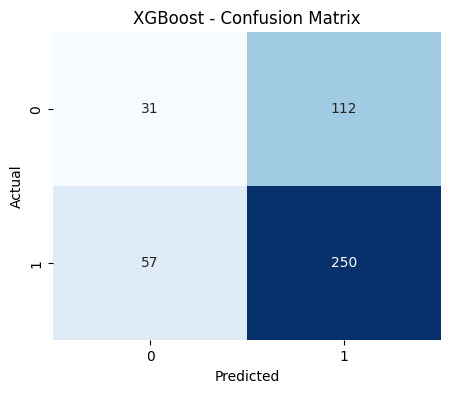

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("=== XGBoost - Confusion Matrix ===")
print(cm)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("XGBoost - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()



=== XGBoost - ROC AUC: 0.5147 ===


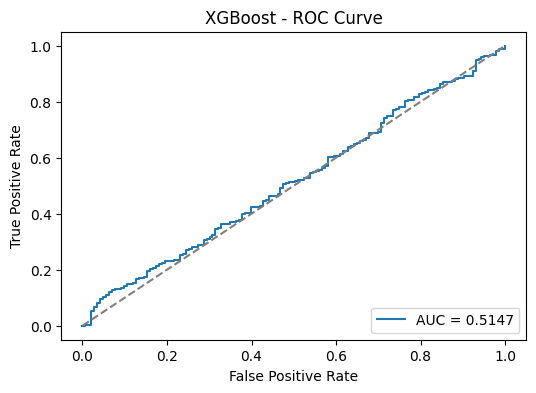

In [ ]:
# ROC Curve
y_proba = pipe.predict_proba(X_test)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
print(f"=== XGBoost - ROC AUC: {roc_auc:.4f} ===")
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost - ROC Curve")
plt.legend(loc='lower right')
plt.show()



In [ ]:
# Save model
joblib.dump(pipe, "crime_predictor_xgb.pkl")
print("Saved model to crime_predictor_xgb.pkl")

Saved model to crime_predictor_xgb.pkl
